<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/Woody_Debris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c('data.table','ggplot2','magrittr','rstatix','plotrix','ggsignif',"googledrive",'openxlsx'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘Rcpp’




In [2]:
install.packages('sf')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’




In [3]:
library(data.table)
library(ggplot2)
library(magrittr)
library(rstatix)
library(ggsignif)
library(plotrix)
library(googledrive)
library(openxlsx)
library(sf)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE



In [4]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=0882605251c548ee9bbe7f8333484dbc&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa1dmdTljNjFELVJyUWNES3JCRXQ2dUd6MkR5RE9vVElnRm9JNXdqUDdKQ3ZJS1l5Q1Q1anR2X19SVy0yakNlZyIsInN0YXRlIjoiMDg4MjYwNTI1MWM1NDhlZTliYmU3ZjgzMzM0ODRkYmMifQ==


In [5]:
drive_download(file = as_id('1uoBy87pdp8sByoTocX6MGIIBpW9KIGC8oZWwzlbXj7Y'), path =  '/content/2024_holidayfarmfire.xlsx', overwrite = FALSE)


File downloaded:

• 2024_holidayfarmfire <id: 1uoBy87pdp8sByoTocX6MGIIBpW9KIGC8oZWwzlbXj7Y>

Saved locally as:

• /content/2024_holidayfarmfire.xlsx



In [6]:
SheetNames<-getSheetNames('/content/2024_holidayfarmfire.xlsx')
print(SheetNames)

data_list <- SheetNames %>%
             lapply(function(x){
                #Read the i'th sheet
             openxlsx::read.xlsx('/content/2024_holidayfarmfire.xlsx', x) %>% data.table
             })

names(data_list) <- SheetNames

[1] "Site Locations"         "Soil Samples"           "CWD"                   
[4] "Decay and burn classes" "Frac BPCA"              "BPCA Standards"        


In [8]:
# /content/lines.gpkg
spatial_transect_dt <- st_read('/content/transect_data.gpkg') %>% data.table
spatial_cwd_dt <- st_read('/content/spatial_cwd.gpkg') %>% data.table
plot_points_dt <- st_read('/content/points.gpkg') %>% data.table
plot_lines_dt <- st_read('/content/lines.gpkg') %>% data.table

Reading layer `transect_data' from data source `/content/transect_data.gpkg' using driver `GPKG'
Simple feature collection with 643 features and 32 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 127638.6 ymin: 50897.42 xmax: 133980.5 ymax: 59427.36
Projected CRS: NAD83(CORS96) / Oregon Eugene zone (m)
Reading layer `spatial_cwd' from data source `/content/spatial_cwd.gpkg' using driver `GPKG'
Simple feature collection with 331 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 129988.5 ymin: 50890.85 xmax: 133823.8 ymax: 59231.15
Projected CRS: NAD83(CORS96) / Oregon Eugene zone (m)
Reading layer `points' from data source `/content/points.gpkg' using driver `GPKG'
Simple feature collection with 23 features and 3 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: 156.0613 ymin: -462.5008 xmax: 859.5093 ymax: -120.557
Geodetic CRS:  WGS 84
Reading layer `new_scratch_layer' from data source `/content/lines.gpkg' using dri

In [9]:
a_plot_lines_dt <- plot_lines_dt[Group == 'A'] %>% st_as_sf %>% st_sample(1000, keepGeometry = TRUE) %>% st_sf %>% st_as_sf %>% data.table
a_plot_lines_dt$Group <- 'A'
b_plot_lines_dt <- plot_lines_dt[Group == 'B'] %>% st_as_sf %>% st_sample(1000, keepGeometry = TRUE) %>% st_sf %>% st_as_sf %>% data.table
b_plot_lines_dt$Group <- 'B'
plot_lines_points_dt <- rbindlist(list(a_plot_lines_dt,b_plot_lines_dt)) %>% st_as_sf %>% st_cast('POINT') %>% data.table

Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
although coordinates are longitude/latitude, st_sample assumes that they are
planar

Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”
although coordinates are longitude/latitude, st_sample assumes that they are
planar

Warning message in st_cast.sf(., "POINT"):
“repeating attributes for all sub-geometries for which they may not be constant”


In [10]:
plot_lines_points_dt <- plot_lines_points_dt %>% data.table
coords_dt <- plot_lines_points_dt %>% st_as_sf %>% st_coordinates %>% data.table
names(coords_dt) <- c('X_new','Y_new')
plot_lines_points_dt <- data.table(plot_lines_points_dt,coords_dt)

In [11]:
coords_dt <- plot_points_dt$geom %>% st_coordinates %>% data.table
names(coords_dt) <- c('X_new','Y_new')
plot_points_dt <- data.table(plot_points_dt,coords_dt)

In [12]:
X_lm <- lm(X~X_new,plot_points_dt[Group =='C' &Y == 0])
Y_lm <- lm(Y~Y_new,plot_points_dt[Group =='C' &X == 0])

plot_points_dt[,Y_test := predict(Y_lm,plot_points_dt)]
plot_points_dt[,X_test := predict(X_lm,plot_points_dt)]

plot_lines_points_dt[,Y_test := predict(Y_lm,plot_lines_points_dt)]
plot_lines_points_dt[,X_test := predict(X_lm,plot_lines_points_dt)]

In [13]:
plot_points_dt[Group == 'A']

Group,X,Y,geom,X_new,Y_new,Y_test,X_test
<chr>,<int>,<int>,<POINT [°]>,<dbl>,<dbl>,<dbl>,<dbl>
A,NA,NA,POINT (167.5407 -149.5215),167.5407,-149.5215,11.0031060,0.8156493
A,NA,NA,POINT (179.0461 -212.1848),179.0461,-212.1848,8.8038049,1.7989929
A,NA,NA,POINT (203.6652 -383.014),203.6652,-383.0140,2.8081941,3.9031485
A,NA,NA,POINT (250.9643 -413.3534),250.9643,-413.3534,1.7433700,7.9457215
A,NA,NA,POINT (742.9057 -442.5383),742.9057,-442.5383,0.7190629,49.9911416


In [14]:
plot_points_dt <- plot_points_dt[order(X_test)]




x <- plot_lines_points_dt[Group == 'A'&X_test<15]$X_test
y <- plot_lines_points_dt[Group == 'A'&X_test<15]$Y_test




# Define the logarithmic model
log_model <- function(x, a, b) {
  a + b * log(x)
}

# Fit the model to the data using nls
fit_A <- nls(y ~ log_model(x, a, b), start = list(a = 1, b = 1))

x <- c(plot_lines_points_dt[Group == 'A'&X_test>15]$X_test,rep(500,1))
y <- c(plot_lines_points_dt[Group == 'A'&X_test>15]$Y_test,rep(0,1))

lin_model_A <- lm(Y_test~X_test,data.table(Y_test=y,X_test=x))



x <- plot_lines_points_dt[Group == 'B'&X_test<15]$X_test
y <- plot_lines_points_dt[Group == 'B'&X_test<15]$Y_test


# Define the logarithmic model
log_model <- function(x, a, b) {
  a + b * log(x)
}
# Fit the model to the data using nls
fit_B <- nls(y ~ log_model(x, a, b), start = list(a = 1, b = 1))

x <- c(plot_lines_points_dt[Group == 'B'&X_test>15]$X_test,rep(500,1))
y <- c(plot_lines_points_dt[Group == 'B'&X_test>15]$Y_test,rep(0,1))

lin_model_B <- lm(Y_test~X_test,data.table(Y_test=y,X_test=x))



`geom_smooth()` using formula = 'y ~ x'
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


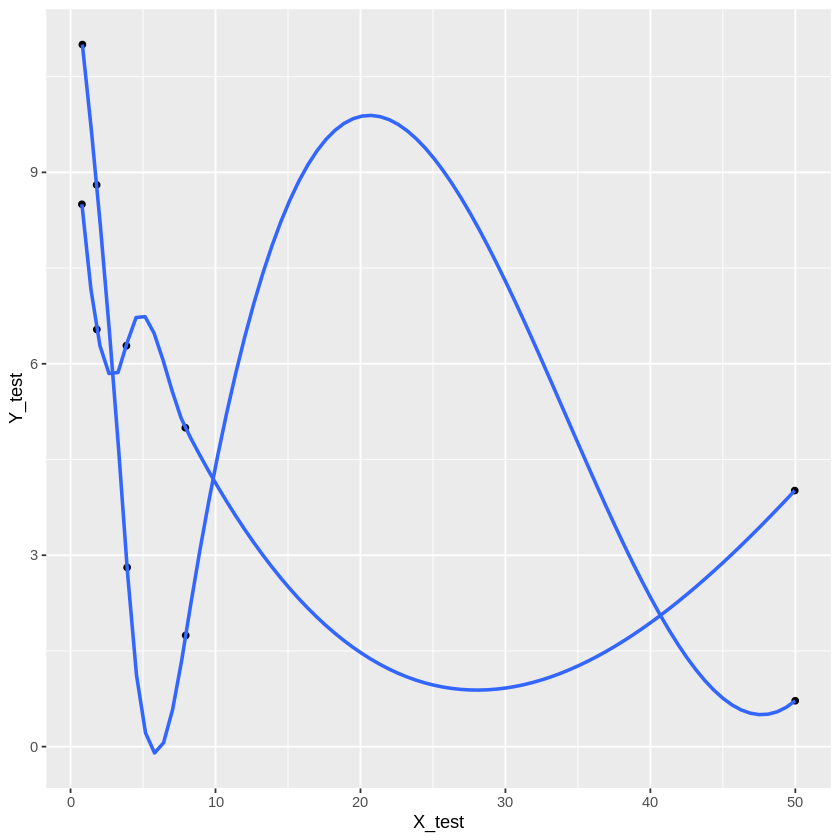

In [15]:
plot_points_dt[Group %in% c('A','B')] %>%
  ggplot(aes(x=X_test,y=Y_test))+
  geom_point() +
  geom_smooth(aes(group=Group),method='loess',span=.8)

In [16]:
fit_dt <-
rbindlist(list(
data.table(Group= 'A',X_test = 1:10,Y_test = log_model(1:10,coef(fit_A)[1],coef(fit_A)[2])),
data.table(Group= 'B',X_test = 1:10,Y_test = log_model(1:10,coef(fit_B)[1],coef(fit_B)[2])),
data.table(Group= 'A',X_test = 11:500,Y_test = predict(lin_model_A,data.table(X_test = 11:500))),
data.table(Group= 'B',X_test = 11:500,Y_test = predict(lin_model_B,data.table(X_test = 11:500))))


)
# fit_dt

In [17]:
diameter_decay_dt <- plot_lines_points_dt[,list(DR = mean(Y_test)),by=(diameter = round(X_test))] [order(diameter)]
nonlin_diameter_decay_dt <-fit_dt[,list(DR = mean(Y_test)),by=(diameter = X_test)] [order(diameter)]

In [18]:
# diameter_decay_dt %>% ggplot(aes(x=diameter,y=DR))+
#   geom_point() +
#   xlim(0,50) +
#   geom_smooth(method = 'gam')

In [19]:
nonlin_diameter_decay_dt[diameter==1][['DR']][1]

[1] 8.227889

In [20]:
nonlin_diameter_decay_dt[diameter==100][['DR']]

[1] 2.139352

In [22]:
percent_decay <- function(DR, year) {
  percent <- (1-exp(-(DR/100) * year)) * 100
  return(percent)
}

nonlin_decay_table <-
function(z){
if(is.na(z)){return(data.table(DR=NA,year_m=NA,decay_m=NA,decay_class = NA))}
per_decay_table <-
z %>% lapply(function(diam){
data.table(diameter = diam,year= 1:500,percent_decay =
1:500 %>%
lapply(function(year){
    percent_decay(nonlin_diameter_decay_dt[diameter==round(diam)][['DR']],year)
    }) %>% unlist)}) %>% rbindlist
per_decay_table$DR  <- nonlin_diameter_decay_dt[diameter==round(z)][['DR']]
rate_decay_table <- per_decay_table[,list(DR = mean(DR),year_m = median(year,na.rm=T),decay_m = median(percent_decay)),by=(decay_class= (percent_decay %>% cut(breaks=c(0,10,20,50,80,90,100)))) ]
return(rate_decay_table)
}

In [23]:
# spatial_cwd_dt %>% head

In [24]:
x_dt <- NULL

In [25]:
spatial_cwd_dt <-
# spatial_cwd_dt %>%
1:nrow(data_list[['CWD']]) %>%
lapply(function(y){
    x_dt <- data_list[['CWD']][y,]

    decay_table <- nonlin_decay_table(x_dt$Width_cm %>% as.numeric)
    # print(decay_table)
    decay_table <- decay_table[if(is.na(x_dt$`Decay_class_1-5` %>% as.numeric)){1}else{x_dt$`Decay_class_1-5`%>% as.numeric},]
    data.table(x_dt,decay_table)  %>% data.table
    }) %>%
rbindlist()

Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 0 rows but longest item has 500; filled with NA”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 0 rows but longest item has 500; filled with NA”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 0 rows but longest item has 500; filled with NA”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 0 rows but longest item has 500; filled with NA”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 0 rows but longest item has 500; filled with NA”
Warning message in as.data.table.list(x, keep.rownames = keep.rownames, check.names = check.names, :
“Item 3 has 0 rows but longest item has 500; filled with NA”
Warning message in as.data.t

In [44]:
burn_class <- utils::read.csv(text = R"---(
1
1
0.95
0.5
0.1
0
)---", header = FALSE) %>% data.table
names(burn_class) <- 'remaining'
burn_class$`Burn_class_1-5` <- c(c(-1,1:5))
burn_class

remaining,Burn_class_1-5
<dbl>,<dbl>
1.00,-1
1.00,1
0.95,2
0.50,3
0.10,4
0.00,5


In [46]:
spatial_cwd_dt <- spatial_cwd_dt %>% merge(burn_class,by='Burn_class_1-5',all=T)

In [47]:
spatial_cwd_dt[,volume:=min(Length_cm,200)*pi*max(Width_cm/2,0)^2,by=1:nrow(spatial_cwd_dt)]

In [28]:
spatial_cwd_dt[,mass_kg:=volume*0.000001*530,by=1:nrow(spatial_cwd_dt)]

In [48]:
spatial_cwd_dt %>% head

Burn_class_1-5,Date,Site,stump,burned_stump,Cardinal_direction,Transect_Position_m,Length_cm,Width_cm,Decay_class_1-5,⋯,Notes,decay_class,DR,year_m,decay_m,volume,mass_kg,decayed_mass_kg,lost_mass_kg,remaining
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,44391,CH4,T,-1.0,N,10.1,-1,-1,-1.0,⋯,NA,NA,NA,NA,NA,0,0,NA,NA,1
-1,44391,CH4,T,-1.0,N,8.6,-1,-1,-1.0,⋯,NA,NA,NA,NA,NA,0,0,NA,NA,1
-1,44391,CH4,T,-1.0,S,2.0,-1,-1,-1.0,⋯,NA,NA,NA,NA,NA,0,0,NA,NA,1
-1,44391,CH4,T,-1.0,W,4.9,-1,-1,-1.0,⋯,NA,NA,NA,NA,NA,0,0,NA,NA,1
-1,44384,L3,T,T,E,3.5,-1,-1,-1.0,⋯,NA,NA,NA,NA,NA,0,0,NA,NA,1
-1,44384,L3,T,T,E,14.0,-1,-1,-1.0,⋯,NA,NA,NA,NA,NA,0,0,NA,NA,1


In [30]:
spatial_cwd_dt[,decayed_mass_kg:=mass_kg*(1-decay_m/100),by=1:nrow(spatial_cwd_dt)]

In [31]:
spatial_cwd_dt[,lost_mass_kg:=mass_kg*(decay_m/100),by=1:nrow(spatial_cwd_dt)]

In [32]:
# spatial_cwd_dt %>% head

Site,decayed_mass_kg,total_input,burn_decayed_mass_kg,burn_mass_ratio,wood_input_rate,wood_departure_rate,wood_accumulation_rate,years_to_capacity,years_to_recovery,exp_group,control
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
CH4,3.5924356,9.0204632,3.59243563,1.0000000,0.37116231,0.139072825,0.232089488,15.478666,0.00000000,H,TRUE
L3,0.2771711,0.3897868,0.16988331,0.6129186,0.04622142,0.008705993,0.037515431,7.388188,2.85983018,L,FALSE
CM1,1.0858740,2.2062944,0.95648166,0.8808403,0.10224041,0.039962405,0.062278004,17.435916,2.07765769,M,TRUE
CL4,5.2776189,11.5374375,5.27761889,1.0000000,0.61277011,0.192103369,0.420666737,12.545843,0.00000000,L,TRUE
CL2,8.1390410,17.2696952,8.13904103,1.0000000,0.64365740,0.294378477,0.349278921,23.302411,0.00000000,L,TRUE
L2,1.6787543,2.8223018,1.20229137,0.7161806,0.22214435,0.055610639,0.166533709,10.080568,2.86106022,L,FALSE
CH3,0.3756664,0.4363803,0.37566637,1.0000000,0.09115049,0.010590500,0.080559991,4.663188,0.00000000,H,TRUE
CH1,18.9186152,43.8902782,18.91861523,1.0000000,1.35519156,0.600391335,0.754800227,25.064401,0.00000000,H,TRUE
H1,0.4541378,0.8209708,0.04541378,0.1000000,0.04041332,0.016367473,0.024045848,18.886331,16.99769796,H,FALSE


Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”


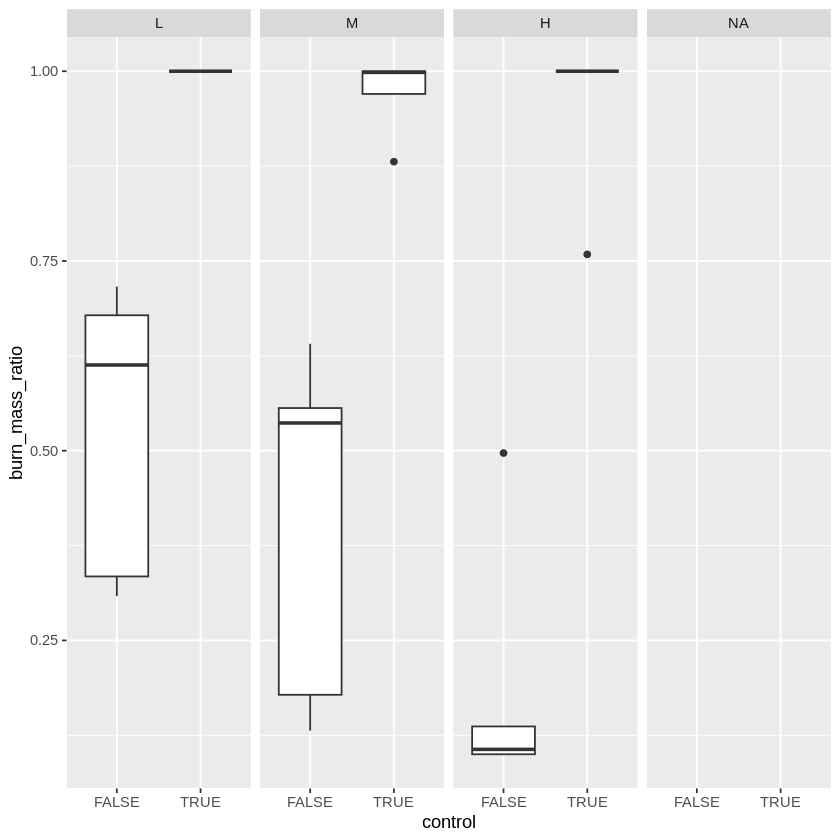

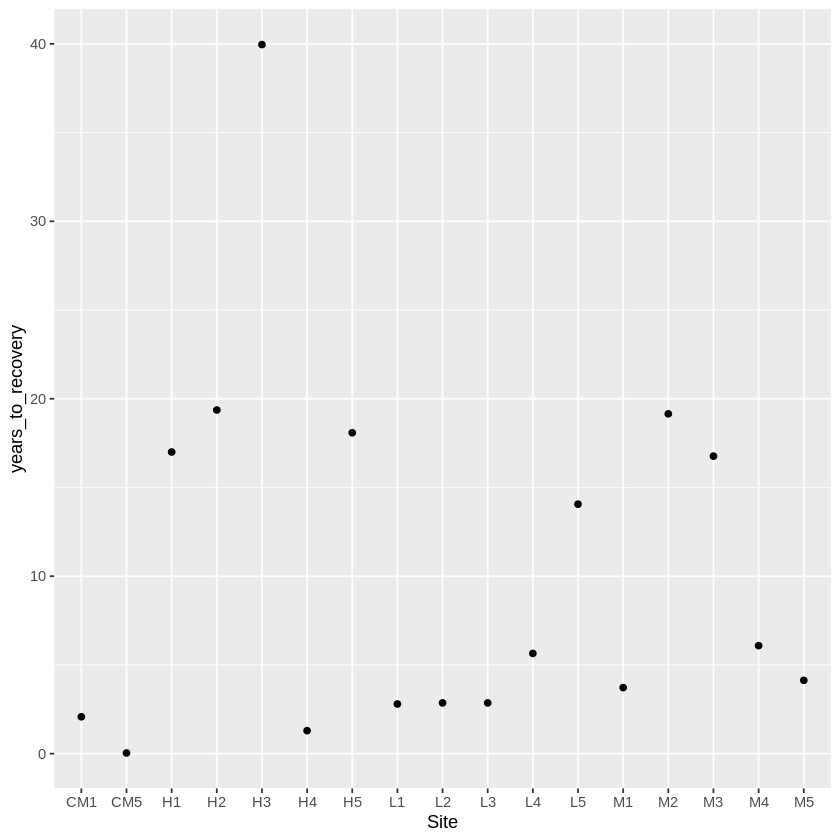

In [74]:
rate_table <-
spatial_cwd_dt[,list(
  decayed_mass_kg = sum(decayed_mass_kg,na.rm=T)/120,
  total_input=sum(mass_kg,na.rm=T)/120,
  burn_decayed_mass_kg = sum(decayed_mass_kg*remaining,na.rm=T)/120,
  burn_mass_ratio = (sum(decayed_mass_kg*remaining,na.rm=T)/120)/(sum(decayed_mass_kg,na.rm=T)/120),
  wood_input_rate = sum(mass_kg/year_m,na.rm=T)/120,
  wood_departure_rate = sum(lost_mass_kg/year_m,na.rm=T)/120,
  wood_accumulation_rate = sum(mass_kg/year_m,na.rm=T)/120 - sum(lost_mass_kg/year_m,na.rm=T)/120,
  years_to_capacity = sum(decayed_mass_kg,na.rm=T)/120/(sum(mass_kg/year_m,na.rm=T)/120 - sum(lost_mass_kg/year_m,na.rm=T)/120),
  years_to_recovery = sum((decayed_mass_kg-decayed_mass_kg*remaining),na.rm=T)/120/(sum(mass_kg/year_m,na.rm=T)/120 - sum(lost_mass_kg/year_m,na.rm=T)/120)

  ),by=Site]
rate_table[,exp_group:=Site %>% gsub('C','',.) %>% gsub("[0-9]", "", .) %>% factor(levels=c('L','M','H'))]
rate_table[,control:=(Site %>% substr(1,1)) %in% 'C']
rate_table
rate_table %>%
  ggplot(aes(y= burn_mass_ratio,x=control ))+
  geom_boxplot(aes()) +
  facet_grid(.~exp_group)

rate_table[years_to_recovery>0] %>%
  ggplot(aes(x=Site,y=years_to_recovery))+
  geom_point(aes())

In [59]:
rate_table %>% fwrite('cwd_rate_table.csv')